In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import glob

from torchvision import models
import tqdm

import time
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle
import math
import random
from torchvision.transforms import RandomCrop
os.chdir('/projectnb/cs585bp/jkoh/')
from SILog import SILogLoss
os.chdir('/projectnb/cs585bp/krishna/project/')

OUT_SIZE = (2200, 1550)

In [2]:
class MonocularDepthDataset(Dataset):
    def __init__(self, df, in_transform=None,out_transform = None ):
        self.df = df
        self.in_transform = in_transform
        self.out_transform = out_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        depth_path = self.df.iloc[idx]['depth']

        image = Image.open(image_path)
        depth = Image.open(depth_path)

        if self.in_transform:
            image = self.in_transform(image)
        if self.out_transform:
            depth = self.out_transform(depth)
        #print(depth_path,depth.shape)
        return image, depth

In [3]:
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge

In [4]:
class vanilla_unet_full(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = torch.cat([x,x,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        #print(block4.shape)
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)

        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)

        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='bilinear', align_corners=True)
        
        out = out4_upsampled
        
        
        return out

In [5]:
model = vanilla_unet_full(n_class=1)
model = nn.DataParallel(model)
model = model.to('cuda')

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<ipython-input-6-9aea19feea06>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-6-9aea19feea06>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, depths in tqdm.tqdm_notebook(train_dataloader):


  0%|          | 0/447 [00:00<?, ?it/s]

78028.13
Train Loss: 9.903465945181964


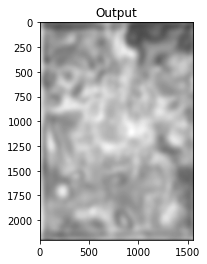

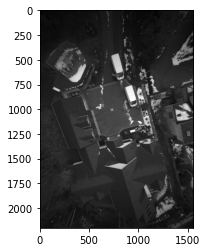

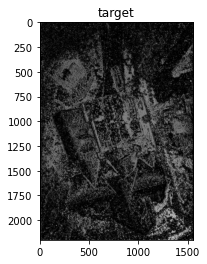

  0%|          | 0/447 [00:00<?, ?it/s]

135072.22
Train Loss: 9.450495896990134


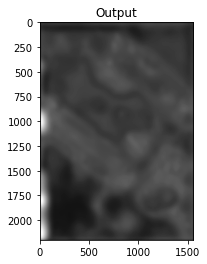

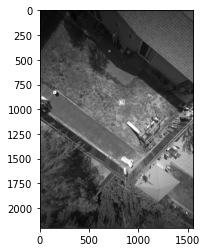

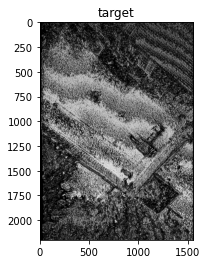

  0%|          | 0/447 [00:00<?, ?it/s]

58529.766
Train Loss: 9.086933430409271


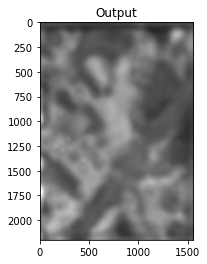

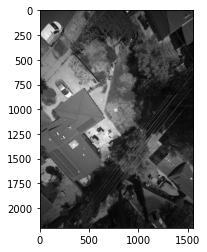

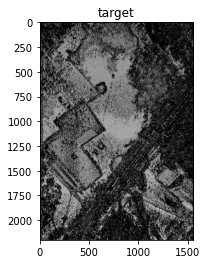

  0%|          | 0/447 [00:00<?, ?it/s]

148677.44
Train Loss: 9.01687022130228


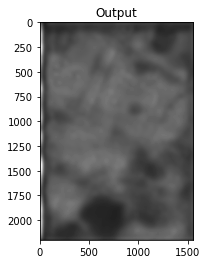

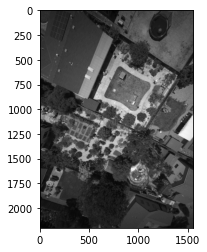

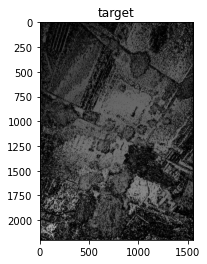

  0%|          | 0/447 [00:00<?, ?it/s]

103645.29
Train Loss: 8.930876140893172


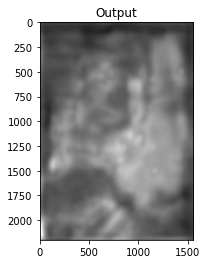

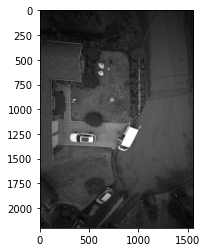

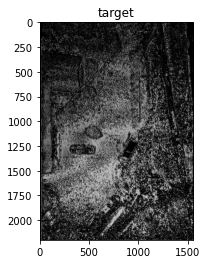

  0%|          | 0/447 [00:00<?, ?it/s]

130923.55
Train Loss: 8.824853790419747


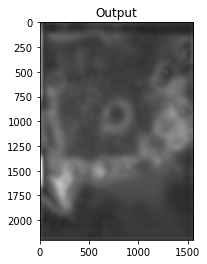

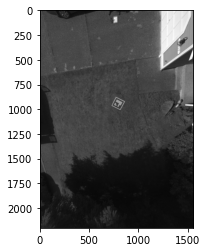

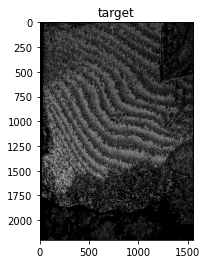

  0%|          | 0/447 [00:00<?, ?it/s]

131387.66
Train Loss: 8.495911148037154


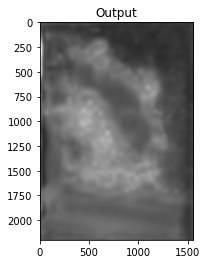

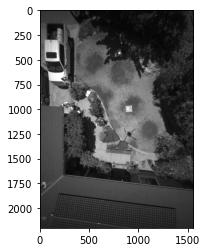

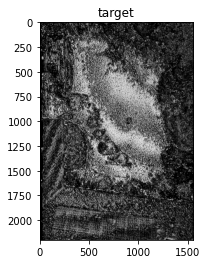

  0%|          | 0/447 [00:00<?, ?it/s]

79324.16
Train Loss: 9.19755381812452


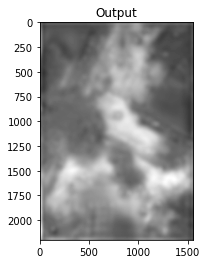

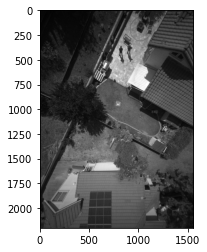

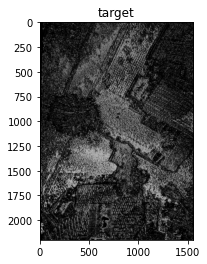

  0%|          | 0/447 [00:00<?, ?it/s]

140499.83
Train Loss: 8.707526844886592


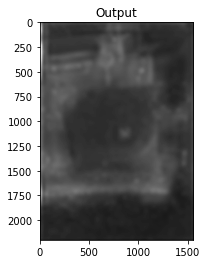

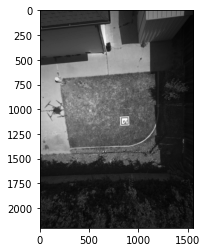

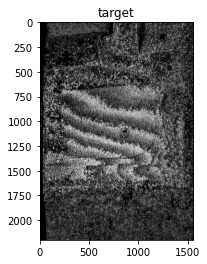

  0%|          | 0/447 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Set hyperparameters, dataset paths, and other configurations
batch_size = 4
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

out_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

df = pd.read_csv('train.csv')
train_dataset = MonocularDepthDataset(df, in_transform = in_transform, out_transform = out_transform)
#val_dataset = MonocularDepthDataset(val_image_paths, val_depth_paths, transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = SILogLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in tqdm.tqdm_notebook(range(num_epochs)):
    #train_loss = train(model, train_dataloader, optimizer, criterion, device)
    
    model.train()
    running_loss = 0.0
    n = 0
    for images, depths in tqdm.tqdm_notebook(train_dataloader):
        images = images.to(device)
        depths = depths.to(device)
        #print(depths.shape)
        optimizer.zero_grad()

        outputs = model(images)
        #print('out shape',outputs.shape)
        loss = criterion(outputs, depths)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n += 1
        if n > 50 : break
    dataiter = iter(train_dataloader)
    example = next(dataiter)
    target = example[1]
    example = example[0]
    #print(example.shape)
    ex_in = example.cuda()
    out_vis = model(ex_in).detach().cpu().numpy()[0][0]
    print(np.max(out_vis))
    #print(out_vis.shape)
    train_loss = running_loss / len(train_dataloader)
    #print(out_vis)
    print("Train Loss:",train_loss)
    out_vis = np.nan_to_num(np.rint((out_vis/np.max(out_vis))*255))
    
    #print(out_vis)
    plt.imshow(out_vis, interpolation='nearest', cmap='gray')
    plt.title("Output")
    plt.show()
    plt.imshow(example[0][0].detach().numpy(), cmap='gray')
    plt.show()
    plt.title("target")
    target = target[0][0].detach().numpy()
    plt.imshow(np.rint((target/np.max(target))*255), cmap='gray')
    plt.show()

    #val_loss = validate(model, val_dataloader, criterion, device)